#### Summary:
This notebook contains code to run ChromVAR on all data and then perform cell type specific genotype differential tests to find motifs differentially accessible between genotypes.

In [1]:
suppressMessages(library(chromVAR))
suppressMessages(library(chromVARmotifs))
suppressMessages(library(motifmatchr))
suppressMessages(library(SummarizedExperiment))
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(TFBSTools))
suppressMessages(library(BSgenome.Mmusculus.UCSC.mm10))

suppressMessages(library(Matrix))
suppressMessages(library(readr))
suppressMessages(library(stringr))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(ggpubr))
suppressMessages(library(qvalue))

set.seed(1234)
options(warn=-1)

#library(patchwork)
#library(BiocParallel)
#register(MulticoreParam(8))
#library(parallel)
#library(car)
#library(pheatmap)
#library(RColorBrewer)
#library(beeswarm)
#library(ggplotify)

In [2]:
outdir <- '/nfs/lab/projects/mouse_pdac/outputs/ChromVAR/231218_v2_cisbp_motifs'

# Load in Seurat object

In [3]:
#read in the object with the fixed peak atac data
rds_fp <- '/nfs/lab/projects/mouse_pdac/231203_2sample_merged_final_wFixedPeaks2.rds'
adata <- readRDS(rds_fp)
adata

An object of class Seurat 
958079 features across 10445 samples within 6 assays 
Active assay: FixPeaks (275403 features, 0 variable features)
 5 other assays present: RNA, RNA_raw, ATAC, SCT, ATAC_CTpeaks
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

# Prepare ChromVAR inputs

### SummarizedExperiment object

In [4]:
#Prep inputs for SummarizedExperiment

#Extract matrix from Seurat object
sc.data <- GetAssayData(adata, slot='data', assay="FixPeaks")
sc.data.stored <- sc.data

# Extract peak locations and reformat into GRanges object
bed = str_split_fixed(rownames(sc.data), "\\-", 3) #This may need to be modified depending on your peak naming convention

gr= GRanges(seqnames = bed[,1], ranges = IRanges(start = as.numeric(bed[,2]), end = as.numeric(bed[,3])))

In [5]:
#Use the matrix and GRanges to make a SummarizedExperiment to put into chromvar and add metadata
fragment.counts <- SummarizedExperiment(assays=list(counts=sc.data), rowRanges=gr)
fragment.counts.stored <- fragment.counts

In [6]:
# Adjust to include any columns from the Seurat object metadata you will use downstream. Easier to include more now.
metrics <- select(adata[[]], orig.ident, nCount_ATAC, nFeature_ATAC, library, Genotype,
                  assigned_celltypes1, Fibroblasts) 
if (length(rownames(metrics)) == sum(rownames(colData(fragment.counts)) == rownames(metrics))) {
    print("Success adding meta data")
    colData(fragment.counts) <- cbind(colData(fragment.counts), metrics[rownames(colData(fragment.counts)),])
} else {
    print("Failed to add meta data, check column names.")
}

[1] "Success adding meta data"


In [7]:
fragment.counts <- addGCBias(fragment.counts, genome=BSgenome.Mmusculus.UCSC.mm10)

### Motifs object

In [8]:
# load in CIS-BP mouse motifs from chromVARmotifs
data("mouse_pwms_v2")
mouse_pwms_v2

PWMatrixList of length 884
names(884): ENSMUSG00000021359_LINE1_Tcfap2a_D_N1 ...

In [9]:
motif.ix <- matchMotifs(mouse_pwms_v2, fragment.counts, genome=BSgenome.Mmusculus.UCSC.mm10)
motif.ix

class: RangedSummarizedExperiment 
dim: 275403 884 
metadata(0):
assays(1): motifMatches
rownames(275403): chr1-10003185-10003685 chr1-10007198-10007698 ...
  chrX-99873469-99873969 chrX-99975218-99975718
rowData names(1): bias
colnames(884): ENSMUSG00000021359_LINE1_Tcfap2a_D_N1
  ENSMUSG00000025927_LINE5_Tcfap2b_D ...
  ENSMUSG00000021540_LINE17865_Smad5_I_N1
  ENSMUSG00000027796_LINE17891_Smad9_I_N1
colData names(1): name

# Run ChromVAR and collect outputs

In [10]:
# Run chromVAR
dev <- computeDeviations(object=fragment.counts, annotations=motif.ix)#, expectation=expected)#
head(dev)

class: chromVARDeviations 
dim: 6 10445 
metadata(0):
assays(2): deviations z
rownames(6): ENSMUSG00000021359_LINE1_Tcfap2a_D_N1
  ENSMUSG00000025927_LINE5_Tcfap2b_D ...
  ENSMUSG00000042596_LINE8_Tcfap2d_I ENSMUSG00000004661_LINE10_Arid3b_D
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(10445): KA_41_1_2_KA_39_1_2_AAACAGCCAAGTAAGC-1
  KA_41_1_2_KA_39_1_2_AAACAGCCAGCACCAT-1 ...
  KA_42_1_2_KA_40_1_2_TTTGTTGGTTGCGCGA-1
  KA_42_1_2_KA_40_1_2_TTTGTTGGTTTAAAGC-1
colData names(7): orig.ident nCount_ATAC ... assigned_celltypes1
  Fibroblasts

In [11]:
#save outputs as a rds
chromvar_out_fp <- file.path(outdir, '231218_mouse_PDAC_FixPeaks_chromvar_v2_cisbp.rds')
saveRDS(dev, chromvar_out_fp)

### Organize ChromVAR outputs

In [15]:
#This is a cell by motif deviation score (aka accessibility) matrix
#extracts z-scores from the chromVAR object
devscores <- deviationScores(dev)

# Variation of accessibiility across deviation scores, basically the standard errror. Null is about 1
variability <- computeVariability(dev)

In [13]:
# Compile relevant barcode metadata (not sure if need to do this but also dev metadata is NULL?)
#Pull in some metadata
info <- data.frame(def   = substring(Cells(adata), 1, 19),
                  def_short   = adata$library,
                  cells = Cells(adata),
                  genotype = adata$Genotype,
                  major_celltypes = gsub(' cells', '', adata$assigned_celltypes1), 
                  celltypes_cafs = gsub(' cells', '', adata$Fibroblasts))

#rename T and NK to remove space
info$major_celltypes[info$major_celltypes == "T and NK"] <- 'T+NK'
info$celltypes_cafs[info$celltypes_cafs == "T and NK"] <- 'T+NK'

In [14]:
#Save devscores, motifdata, and info
write.table(devscores, file=file.path(outdir,'devscores.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE)
write.table(info, file=file.path(outdir,'info_table.txt'),quote = FALSE, sep='\t')
write.table(variability, file=file.path(outdir,'variability.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE, sep='\t')

# Perform Differential Analysis on ChromVAR Outputs with differentialDeviations

### Run differentialDeviations to pull out differentially accessible motifs across genotype in each cell type (t-test)

In [16]:
diff_dev_dir <- file.path(outdir,'dif_dev')
dir.create(diff_dev_dir, showWarnings=FALSE)

In [17]:
celltypes <- unique(dev$Fibroblasts)
names(celltypes) <- unique(info$celltypes_cafs)
celltypes

Ductal          Neutrophils          Endothelial 
      "Ductal cells"        "Neutrophils"  "Endothelial cells" 
        Perivascular                 T+NK            Dendritic 
"Perivascular cells"     "T and NK cells"    "Dendritic cells" 
               myCAF             EMT-like          Macrophages 
             "myCAF"     "EMT-like cells"        "Macrophages" 
              Acinar                 iCAF                    B 
      "Acinar cells"               "iCAF"            "B cells" 
               apCAF 
             "apCAF"

In [18]:
# Loop through cell types and run differentialDeviations by genotype, output results
for (celltype in names(celltypes)){
    print(celltype)
    
    # Subset the ChromVAR object for the cell type
    dev_sub <- dev[,dev$Fibroblasts==celltypes[[celltype]]]
    print(dim(colData(dev_sub)))
    
    # Perform differential deviations with ChromVAR's built in methods
    difdev_sub <- differentialDeviations(dev_sub, "Genotype", parametric=TRUE, alternative='two.sided')
    num_sig <- table(difdev_sub$p_value_adjusted < 0.1)['TRUE']
    if (!is.na(num_sig)){
        print(paste0('Significantly differential motifs: ', num_sig))
    
        # Save outputs
        difdev_df <- difdev_sub[order(difdev_sub$p_value_adjusted, decreasing = F),]
        out_fp <- file.path(diff_dev_dir, sprintf('%s_difDeviations_by_geno.txt',celltype))
        write.table(difdev_df, out_fp, sep='\t', quote=FALSE)
    } else {
        print('No significantly differential motifs!')
    }
}

[1] "Ductal"
[1] 3215    7
[1] "Significantly differential motifs: 491"
[1] "Neutrophils"
[1] 2290    7
[1] "Significantly differential motifs: 522"
[1] "Endothelial"
[1] 314   7
[1] "Significantly differential motifs: 61"
[1] "Perivascular"
[1] 257   7
[1] "Significantly differential motifs: 177"
[1] "T+NK"
[1] 1023    7
[1] "Significantly differential motifs: 357"
[1] "Dendritic"
[1] 241   7
[1] "Significantly differential motifs: 89"
[1] "myCAF"
[1] 464   7
[1] "Significantly differential motifs: 221"
[1] "EMT-like"
[1] 222   7
[1] "Significantly differential motifs: 49"
[1] "Macrophages"
[1] 515   7
[1] "Significantly differential motifs: 139"
[1] "Acinar"
[1] 246   7
[1] "Significantly differential motifs: 75"
[1] "iCAF"
[1] 101   7
[1] "Significantly differential motifs: 116"
[1] "B"
[1] 1471    7
[1] "No significantly differential motifs!"
[1] "apCAF"
[1] 86  7
[1] "No significantly differential motifs!"


### Make more comprehensive output files 
Include: average dev scores, delta values, pvalue and padj

In [19]:
celltypes <- c('Acinar','Dendritic','Ductal','EMT-like','Endothelial','iCAF',
               'Macrophages','myCAF','Neutrophils','Perivascular','T+NK')
table(celltypes %in% unique(info$celltypes_cafs))


TRUE 
  11 

In [20]:
subset_col <- 'celltypes_cafs' #info col to subset cell types based on
comp_col <- 'genotype' #info col to run comparisons based on
comp_groups <- c('AKPC','KPC') #the two groups to do comparisons between
delta_cutoff <- 1
padj_cutoff <- 0.1

for (celltype in celltypes){
    subset_value <- celltype
    
    # Cut down devscores and info to the subset of interest (celltype here)
    info_cut <- info[info[,subset_col] == subset_value,]    
    dev_cut <- as.data.frame(t(devscores[,row.names(info_cut)]))
    
    # Calculate average devscores across comp_groups and delta devscores between them
    means1 <- colMeans(dev_cut[info_cut[,comp_col] == comp_groups[1],],na.rm=T)
    means2 <- colMeans(dev_cut[info_cut[,comp_col] == comp_groups[2],],na.rm=T)
    deltas <- means1-means2
    
    # Read in differential test results and reorder to match motif order in dev_cut
    sig_fp <- file.path(diff_dev_dir, sprintf('%s_difDeviations_by_geno.txt',celltype))
    sig_df1 <- read.table(sig_fp, sep='\t', header=T)
    sig_df <- sig_df1[colnames(dev_cut),]
    
    # Prep all results df to write
    data <- data.frame(dev_AKPC=means1, dev_KPC=means2, diff=deltas, pval=sig_df$p_value,
                       log10p=log10(sig_df$p_value), padj=sig_df$p_value_adjusted)
    data_sort <- data[order(data$pval),]
    out_fp <- file.path(diff_dev_dir, sprintf('%s_difDeviations_by_geno_wDevs_FINAL.txt',celltype))
    write.table(data_sort, out_fp, sep='\t',quote=F)
    
    # Write only sig outputs to another file
    data_sort$pass <- ifelse(abs(data_sort$diff) <= delta_cutoff, 'no', #doesn't pass delta cutoff
                        ifelse(data_sort$padj >= padj_cutoff, 'no', #doesn't pass padj cutoff
                               'yes'))
    data_sig <- data_sort[data_sort$pass == 'yes',]
    out_fp2 <- file.path(diff_dev_dir, sprintf('%s_difDeviations_by_geno_wDevs_FINAL.sig_motifs.txt',celltype))
    write.table(data_sig, out_fp2, sep='\t', quote=F)
}

### Volcano Plots

In [21]:
options(scipen=999)

In [22]:
### Function to make a Volcano plot from ChromVar results (using geno_wDevs_FINAL files)
### inputs: devscores_df (deviation scores for motifs x barcodes), sig_df (motif x p_value and p_value_adjusted), 
### info_df (barcode x metadata), subset_col (column in info_df to subset barcodes for), subset_value (what value to subset on)
### split_col (column in info_df to split barcodes for), comp_col (column in info_df for x-axis diff comparison - can only be two things)
### comp_groups (ordered vector of 2 groups to calculate delta values for)
make_chromVAR_volcano <- function(res_fp, celltype, delta_cutoff=1, padj_cutoff=0.1){
    # Read in compiled ChromVAR outputs file
    data <- read.table(res_fp, sep='\t', header=1)
    
    # Prep plot inputs
    data$color <- ifelse(abs(data$diff) <= delta_cutoff, 'grey', #doesn't pass delta cutoff
                         ifelse(data$padj >= padj_cutoff, 'grey', #doesn't pass padj cutoff
                                ifelse(data$diff < 0, 'red', #negative diff
                                       'green'))) #positive diff 
    data$label <- NA
    to_label <- subset(data, abs(diff) > delta_cutoff & padj < padj_cutoff)
    data[row.names(to_label),]$label <- str_split_fixed(row.names(to_label), '_', 3)[,3]
    
    #get lowest -log10p that passes padj threshold for horizontal line?
    p_cutoff <- -log10(max(data[data$color != 'grey','pval'],na.rm=TRUE))
    
    # Make Volcano plot
    options(repr.plot.width=7, repr.plot.height=6.5)
    theme_set(theme_classic())
    p1 <- ggplot(data=data, aes(x=diff, y=-log10p, col=color, label=label)) +
            geom_point(aes(alpha=0.7, size=1)) + 
            scale_color_manual(values=c('grey'='#5C5C5C', 'green'='#5DBD19', 'red'='#BD1919')) +
            geom_vline(xintercept=c(-delta_cutoff, 0, delta_cutoff), col="grey", linetype='dashed') + 
            geom_hline(yintercept=p_cutoff, col="grey", linetype='dashed') + 
            ggrepel::geom_text_repel(col=c("black"), size=5) +
            xlab('Devscore difference (AKPC - KPC)') + 
            ylab('-log10(p-value)') + ggtitle(celltype) + 
            theme(legend.position = "none", panel.border=element_rect(colour = 'black', fill=NA), 
                  axis.title.x=element_text(size=18, vjust=0.5), axis.text.x=element_text(size=15, vjust=0.5),
                  axis.title.y=element_text(size=18, vjust=0.5), axis.text.y=element_text(size=15, vjust=0.5)) 

    return(p1)
}

In [23]:
plt_dir <- file.path(diff_dev_dir,'plots','volcanos')

In [24]:
#read in pvalues from stat test

volcanos <- list()
for (celltype in celltypes){
    res_fp <- file.path(diff_dev_dir, sprintf('%s_difDeviations_by_geno_wDevs_FINAL.txt',celltype))
    if (file.exists(res_fp)){
        p1 <- make_chromVAR_volcano(res_fp, celltype, 1, 0.1)
        
        #write plot to png then save in list for composite figure
        out_fp <- file.path(plt_dir, sprintf('%s_difDeviations_by_geno_volcano.png',celltype))
        ggsave(out_fp, device='png', width=7, height=7, units='in') 
        volcanos[[celltype]] <- p1
    }
}

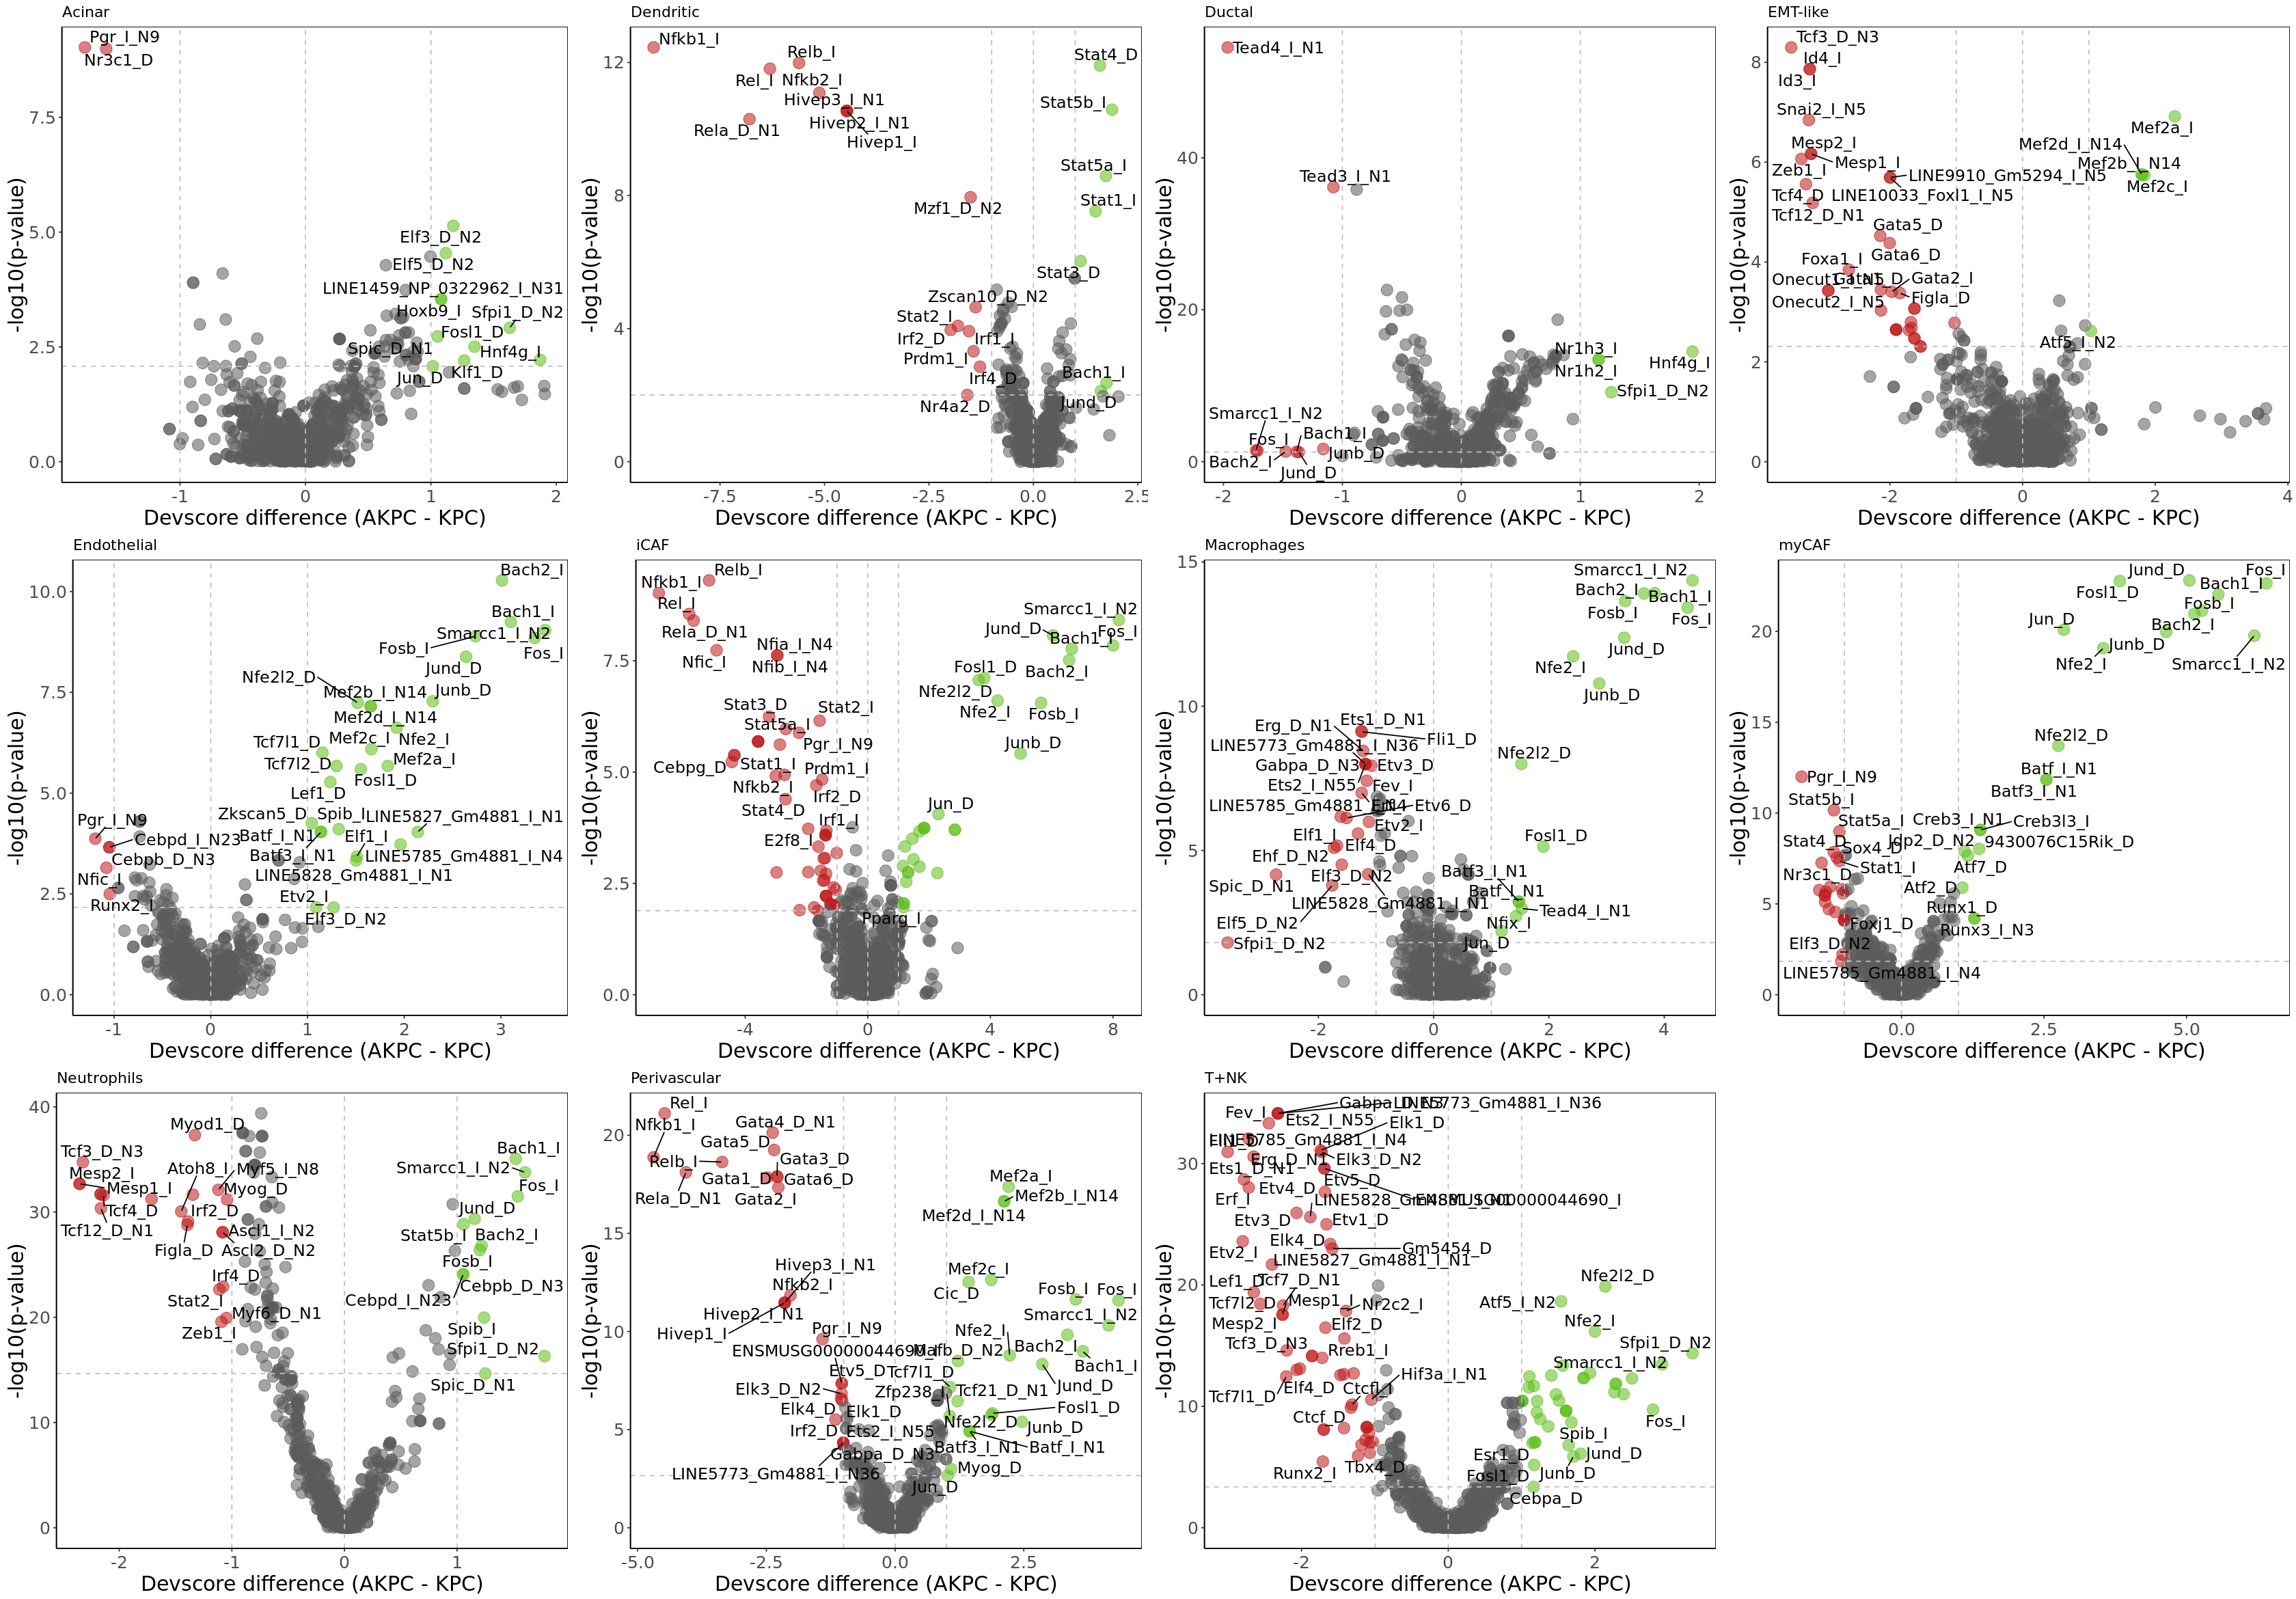

In [25]:
#make composite figure of all volcanos
options(repr.plot.width=28, repr.plot.height=19.5)
ggarrange(plotlist = volcanos, nrow=3, ncol=4)
out_fp <- file.path(plt_dir, 'all_celltype_volcanos.png')
ggsave(out_fp, device='png', width=28, height=21, units='in') 

# Make more motif plots for cell types of interest (per motif violin plots)

In [26]:
#take out B cells and apCAFs since they had no differential motifs
celltypes <- c('Acinar','Dendritic','Ductal','EMT-like','Endothelial','iCAF',
               'Macrophages','myCAF','Neutrophils','Perivascular','T+NK')

In [27]:
ct_colors <- c('Acinar'='#251351', 'B'='#3B52A5', 'Dendritic'='#5AB1BB', 
               'Ductal'='#618040', 'EMT-like'='#AFE079', 'Endothelial'='#FF773D',
               'Macrophages'='#CAA9DE', 'Neutrophils'='#D84727',
               'Perivascular'='#EDA2C0', 'T+NK'='#E3C15D', 'myCAF'='#710CAB',
               'apCAF'='#4FF0E0', 'iCAF'='#C2C0C0', 'bulk'='#000000')

### Make plots for motifs of interest

In [49]:
### Function to make a boxplot for a select motif in a select cell type (using raw Deviation values)
### Version with custom colors!
make_geno_boxplot_ct2 <- function(devscores, info, celltype, motif, motif_short, ct_color){
    box_data <- as.data.frame(devscores[motif,])
    colnames(box_data) <- 'Deviations'
    box_data$Celltype <- info$celltypes_cafs
    box_data$Genotype <- info$genotype
    
    color1 <- ct_color
    color2 <- colorRampPalette(colors = c('black',color1))(4)[3]

    options(repr.plot.width=6, repr.plot.height=5)
    theme_set(theme_classic())
    p1 <- ggplot(filter(box_data, Celltype==celltype), aes(x=Genotype, y=Deviations)) +
        geom_violin(aes(fill=Genotype)) + 
        geom_boxplot(fill='white', alpha=0.5) + 
        scale_fill_manual(values=c('KPC'=color1,'AKPC'=color2)) +
        ggtitle(paste(celltype,motif_short)) +
        theme(legend.position='none', panel.border=element_rect(colour = 'black', fill=NA), 
              axis.title.x=element_text(size=18, vjust=0.5), axis.text.x=element_text(size=15, vjust=0.5),
              axis.title.y=element_text(size=18, vjust=0.5), axis.text.y=element_text(size=15, vjust=0.5),
              title=element_text(size=20))     
    return(p1)
}

In [35]:
### Wrapper to make boxplots only for cell types with significant difference in deviation for a motif
sig_geno_boxplot_wrapper <- function(motif, motif_short, devscores, info, celltypes, dif_dev_dir, out_dir,
                                     ct_colors, padj_cutoff=0.1, delta_cutoff=1){
    plots <- list()
    
    # For each cell type read in the dif dev results and assess whether the motif passes thresholds
    for (celltype in celltypes){
        dif_dev_fp <- file.path(dif_dev_dir,sprintf('%s_difDeviations_by_geno_wDevs_FINAL.txt',celltype))
        dif_devs <- read.table(dif_dev_fp, sep='\t')
        if (dif_devs[motif,]$padj < padj_cutoff & abs(dif_devs[motif,]$diff) > delta_cutoff){
            # Create boxplot if the motif does pass filters!
            plots[[celltype]] <- make_geno_boxplot_ct2(devscores, info, celltype, motif, motif_short, ct_colors[[celltype]])
        } else{
            #print(sprintf('%s motif does not pass padj and delta filters in %s cells',motif, celltype))
        }
    }
    
    # Assemble final figure based on how many plots we have
    if(length(plots) < 5){
        plot_width <- 6 * length(plots)
        plot_height <- 6
        ncols <- length(plots)
        nrows <- 1
    } else {
        plot_width <- 30
        plot_height <- 6 * ceiling(length(plots)/5)
        ncols <- 5
        nrows <- ceiling(length(plots)/5)
    }

    # Assemble composite figure
    if (length(plots) > 0){
        options(repr.plot.width=plot_width,repr.plot.height=plot_height)
        figure <- ggarrange(plotlist = plots, nrow=nrows, ncol=ncols)
            
        #write the plot to a file
        out_fp <- file.path(out_dir, sprintf('motif_%s_all_sig_diff_devs.png', motif))
        ggsave(out_fp, device='png', width=plot_width/1.5, height=plot_height/1.5, units='in')        
        print(figure)
    }
}

### Plot motifs of interest in all cell types they are sig diff in

In [54]:
motifs_of_interest <- c('Smad','Fos','Jun')

In [55]:
all_motifs <- row.names(devscores)
motifs_subset <- all_motifs[grepl(paste(motifs_of_interest, collapse='|'), all_motifs)]
motifs_subset_short <- str_split_fixed(motifs_subset, '_', 3)[,3]
names(motifs_subset_short) <- motifs_subset
motifs_subset_short

ENSMUSG00000003545_LINE172_Fosb_I        ENSMUSG00000021250_LINE181_Fos_I 
                               "Fosb_I"                                 "Fos_I" 
     ENSMUSG00000024912_LINE189_Fosl1_D      ENSMUSG00000029135_LINE202_Fosl2_D 
                              "Fosl1_D"                               "Fosl2_D" 
       ENSMUSG00000052684_LINE240_Jun_D       ENSMUSG00000052837_LINE241_Junb_D 
                                "Jun_D"                                "Junb_D" 
      ENSMUSG00000071076_LINE258_Jund_D     ENSMUSG00000032402_LINE1698_Smad3_D 
                               "Jund_D"                               "Smad3_D" 
 ENSMUSG00000024515_LINE7356_Smad4_I_N1  ENSMUSG00000024563_LINE7358_Smad2_I_N1 
                           "Smad4_I_N1"                            "Smad2_I_N1" 
 ENSMUSG00000031681_LINE7378_Smad1_I_N1 ENSMUSG00000021540_LINE17865_Smad5_I_N1 
                           "Smad1_I_N1"                            "Smad5_I_N1" 
ENSMUSG00000027796_LINE17891_Smad9_I_N1 
                           "Smad9_I_N1"

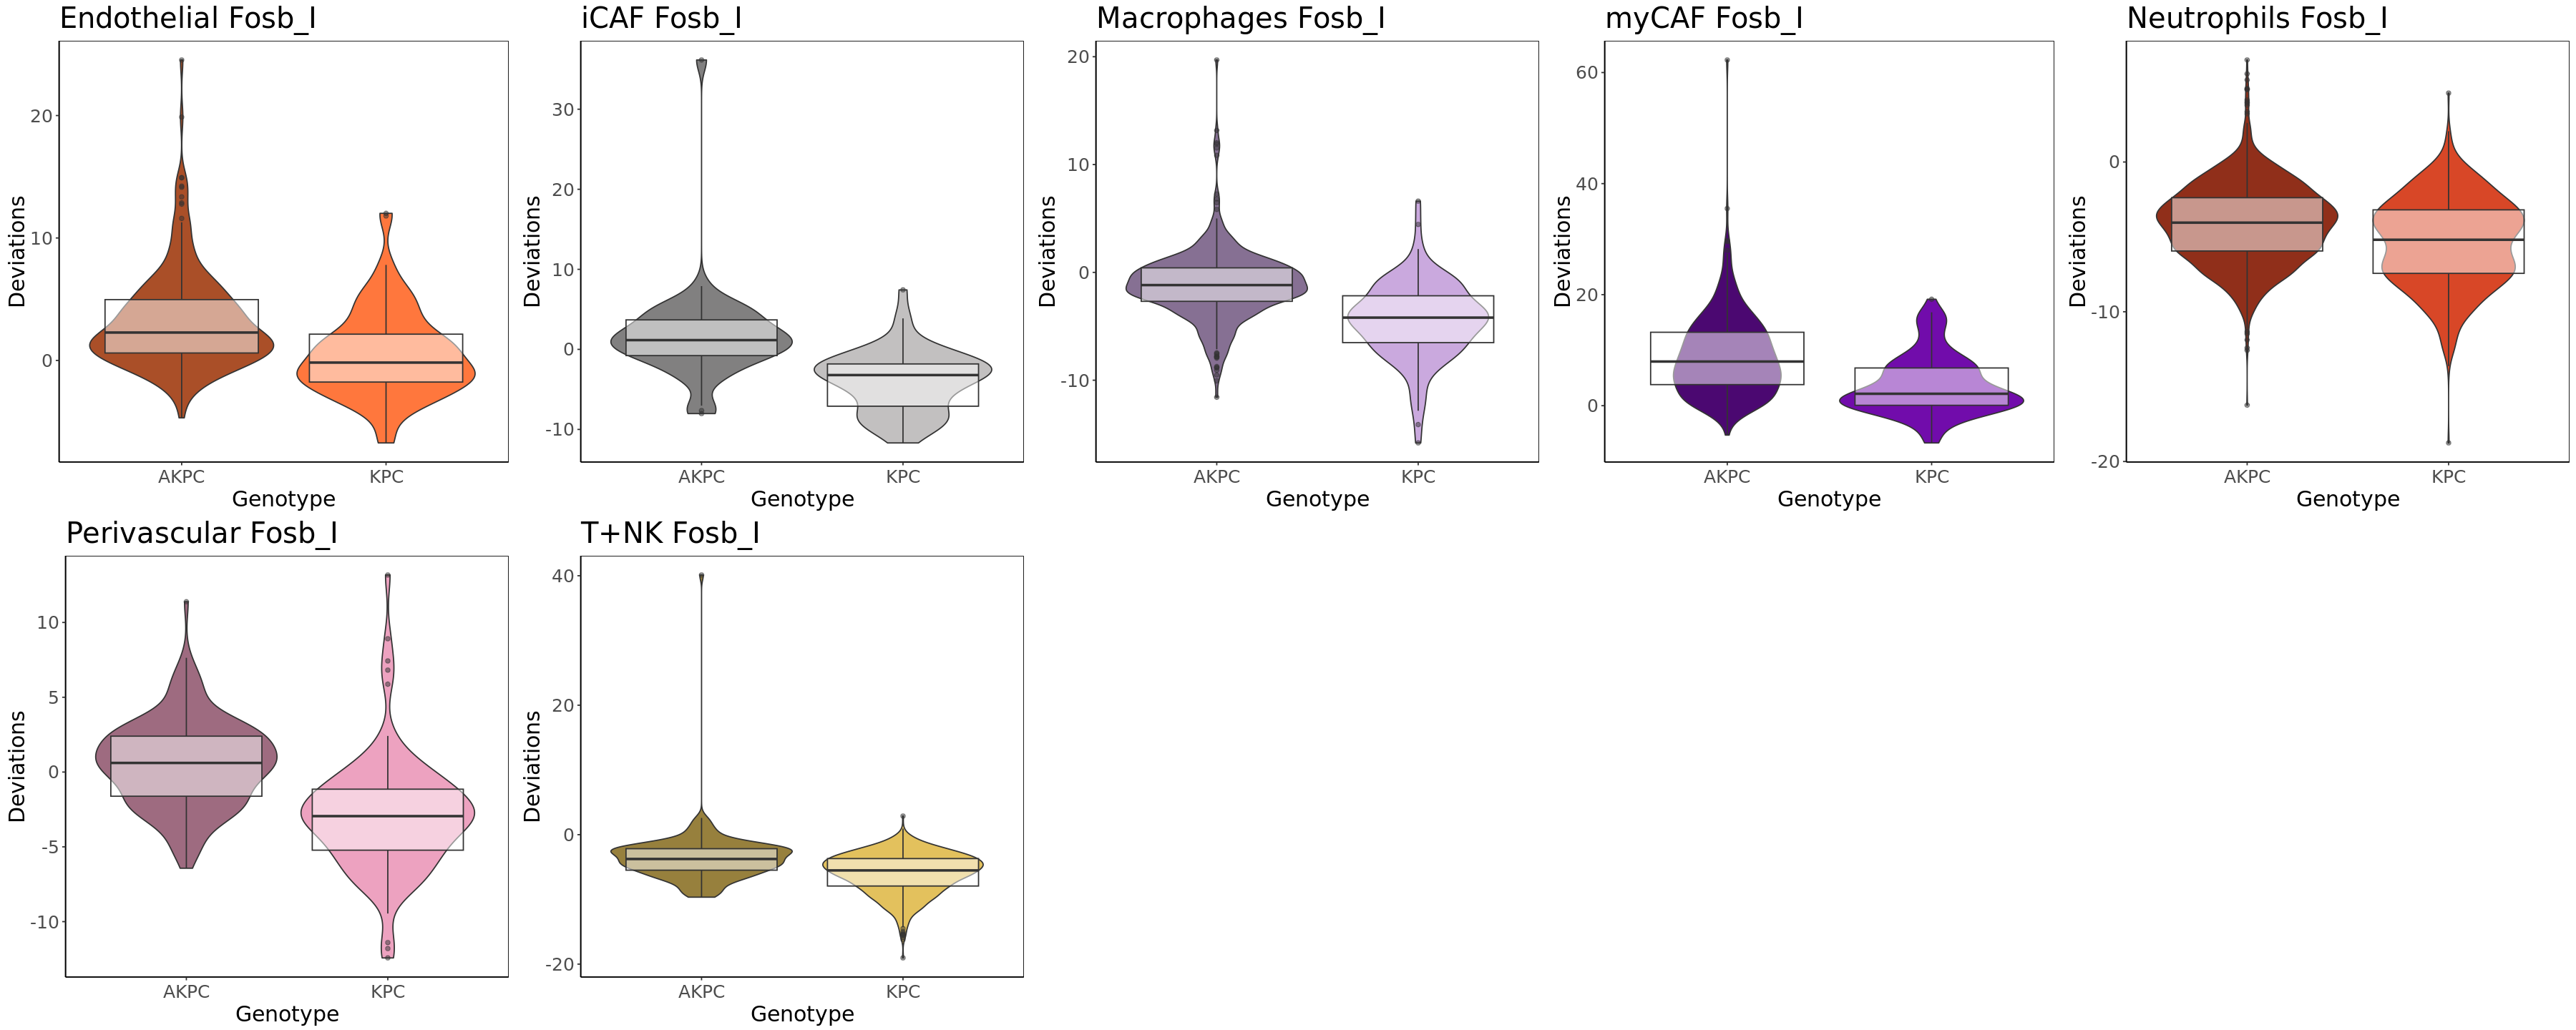

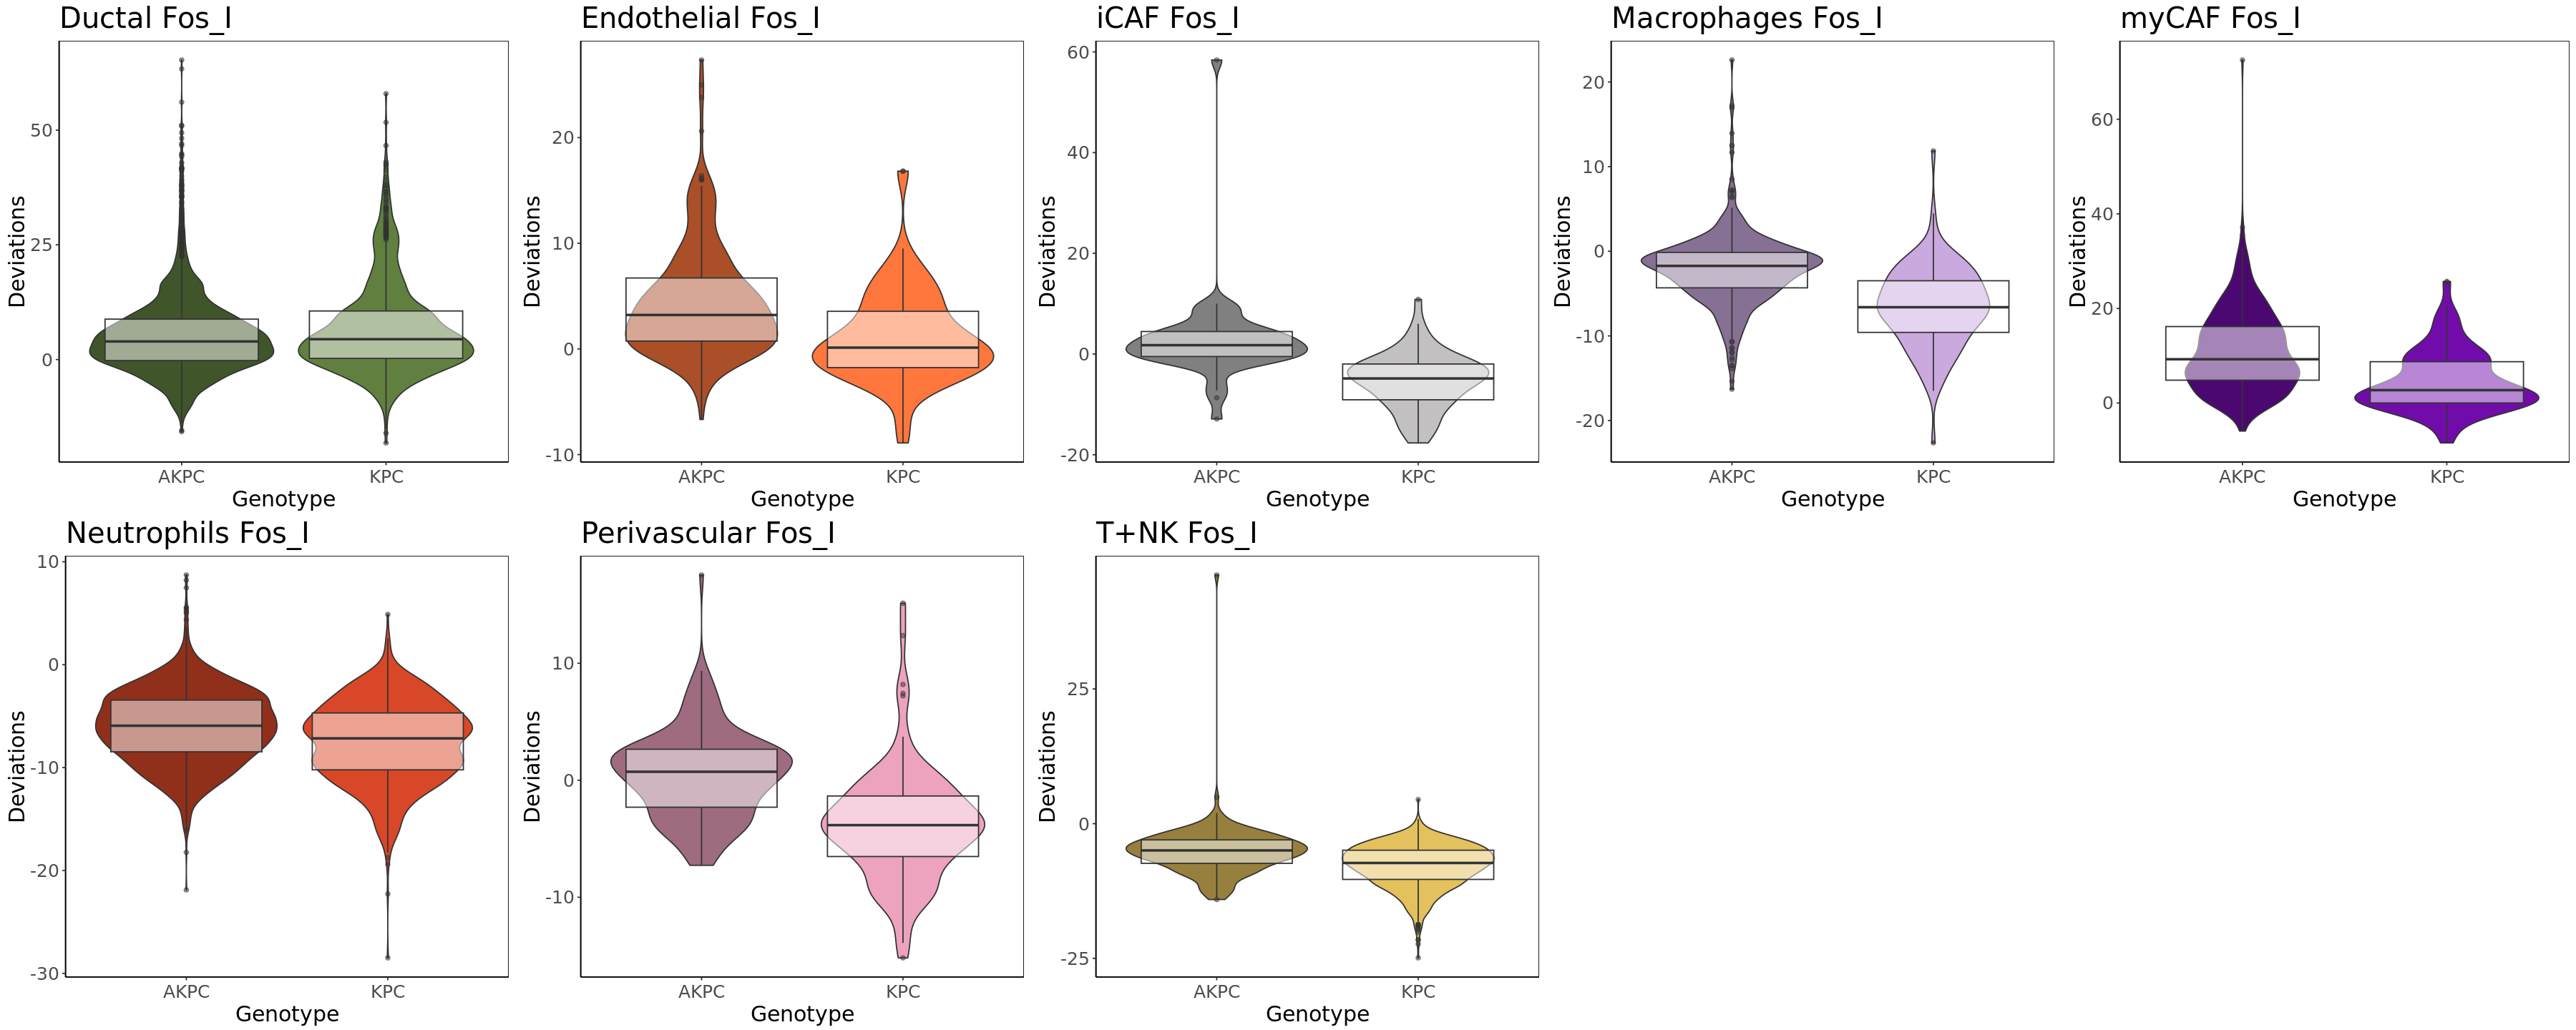

In [59]:
for (motif in motifs_subset[c(1,2)]){
    sig_geno_boxplot_wrapper(motif, motifs_subset_short[[motif]], devscores, info, celltypes, diff_dev_dir, plt_dir, ct_colors)
}

### Plot all sig diff motifs for cell type of interest

In [60]:
### Function to plot all sig diff motifs for a cell type of interest (plot wrapper basically)

plot_all_ct_sig_motifs <- function(celltype, devscores, info, dif_dev_dir, out_dir, ct_colors, padj_cutoff=0.1, delta_cutoff=1){
    # For each cell type read in the dif dev results and assess whether the motif passes thresholds
    dif_dev_fp <- file.path(dif_dev_dir,sprintf('%s_difDeviations_by_geno_wDevs_FINAL.txt',celltype))
    dif_devs <- read.table(dif_dev_fp, sep='\t')    
    
    # Pull out all sig motifs for the cell type
    dif_devs_sig <- subset(dif_devs, dif_devs$padj < padj_cutoff & abs(dif_devs$diff) > delta_cutoff)
    print(sprintf('%s significantly different motifs in %s cells (KPC vs. AKPC)', as.character(dim(dif_devs_sig)[1]), celltype))
    
    # Make plots for each sig motif
    plots <- list()
    for(motif in row.names(dif_devs_sig)){
        motif_short <- str_split_fixed(motif,'_',3)[,3]
        plots[[motif]] <- make_geno_boxplot_ct2(devscores, info, celltype, motif, motif_short, ct_colors[[celltype]])
    }
    
    # Assemble final figure based on how many plots we have
    if(length(plots) < 5){
        plot_width <- 6 * length(plots)
        plot_height <- 6
        ncols <- length(plots)
        nrows <- 1
    } else {
        plot_width <- 30
        plot_height <- 6 * ceiling(length(plots)/5)
        ncols <- 5
        nrows <- ceiling(length(plots)/5)
    }

    # Assemble composite figure
    if (length(plots) > 0){
        options(repr.plot.width=plot_width,repr.plot.height=plot_height)
        figure <- ggarrange(plotlist = plots, nrow=nrows, ncol=ncols)
            
        #write the plot to a file
        out_fp <- file.path(out_dir, sprintf('%s_cells_all_sig_diff_devs.png', celltype))
        ggsave(out_fp, device='png', width=plot_width/1.5, height=plot_height/1.5, units='in')        
        print(figure)
    }
    
}

In [61]:
celltypes_of_interest <- c('Ductal','EMT-like','myCAF','iCAF')
for(celltype in celltypes_of_interest){
    plot_all_ct_sig_motifs(celltype, devscores, info, diff_dev_dir, plt_dir, ct_colors)
}

[1] "12 significantly different motifs in Ductal cells (KPC vs. AKPC)"
[1] "38 significantly different motifs in EMT-like cells (KPC vs. AKPC)"
[1] "43 significantly different motifs in myCAF cells (KPC vs. AKPC)"
[1] "79 significantly different motifs in iCAF cells (KPC vs. AKPC)"


# Print out sessionInfo

In [62]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] qvalue_2.26.0                      ggpubr_0.5.0                      
 [3] ggplot2_3.4.4                      plyr_1.8.8                        
 [5] dplyr_1.0.10                       stringr_1.4.1                     
 [7] readr_2.1.1             